In [53]:
#!git clone https://github.com/fany02656/Typicality_project.git

Cloning into 'Typicality_project'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 246 (delta 3), reused 150 (delta 2), pack-reused 94
Receiving objects: 100% (246/246), 19.76 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Git clone之后把'Car_Plane'文件夹rename为'Vehicle', 'lighthouse'->'Lighthouse', 'church'->'Church'.

Banana的png我load有问题，就先删掉了。

typicality_score是按Breden的paper里计算的，image process我们还可以再讨论。

感觉所有的score都偏低，可以其他的model也试一下，可能只是GoogLeNet的问题，也有可能需要重新找一些图替换，也有可能是因为我process的问题。

仅作参考，继续讨论。

In [18]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [67]:
from PIL import Image
from torchvision import transforms
import os

path='/content/drive/MyDrive/typicality/Typicality_project/Image'
images={}
directory=['Landscape_Scenery/Mountain', 'Landscape_Scenery/Beach', 
           'Daily_Object/Mug', 'Daily_Object/Banana', 
           'Vehicle/Car', 'Vehicle/Plane', 
           'Architecture/Lighthouse', 'Architecture/Church']

for dir in directory:
  images[dir]=[file for file in os.listdir(path+'/'+dir)]

In [39]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [68]:
#type prob cate+filename
all_img={'type':[], 'typicality_score': [], 'dir':[]}

In [69]:
for cate, filename in images.items():
  for f in filename:
    dir=os.path.join(path,cate,f)
    img=Image.open(dir)
    #print(dir)
    input_tensor=preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
      input_batch= input_batch.to('cuda')
      model.to('cuda')

    with torch.no_grad():
      output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    typ_score=round(float(probabilities.max()*100),1)

    all_img['dir'].append(dir)
    all_img['typicality_score'].append(typ_score)
    if 'Mountain' in cate:
      all_img['type'].append('Mountain')
    if 'Beach' in cate:
      all_img['type'].append('Beach')
    if 'Mug' in cate:
      all_img['type'].append('Mug')
    if 'Banana' in cate:
      all_img['type'].append('Banana')
    if 'Car' in cate:
      all_img['type'].append('Car')
    if 'Plane' in cate:
      all_img['type'].append('Plane')
    if 'Lighthouse' in cate:
      all_img['type'].append('Lighthouse')
    if 'Church' in cate:
      all_img['type'].append('Church')

    #print('Typicality of ',f, ' = ',probabilities.max()*100)

/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m1.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m14.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m6.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m12.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m7.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m15.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m18.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m2.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m10.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landscape_Scenery/Mountain/m3.jpg
/content/drive/MyDrive/typicality/Typicality_project/Image/Landsc

In [70]:
import pandas as pd
all_img_df=pd.DataFrame(all_img)
all_img_df.head()
#len(all_img_df)

,type,typicality_score,dir
0,Mountain,64.2,/content/drive/MyDrive/typicality/Typicality_p...
1,Mountain,37.4,/content/drive/MyDrive/typicality/Typicality_p...
2,Mountain,44.2,/content/drive/MyDrive/typicality/Typicality_p...
3,Mountain,20.3,/content/drive/MyDrive/typicality/Typicality_p...
4,Mountain,50.0,/content/drive/MyDrive/typicality/Typicality_p...


In [71]:
all_img_df['type'].value_counts()

Banana        25
Mug           22
Mountain      20
Beach         20
Lighthouse    19
Church        18
Plane         16
Car           16
Name: type, dtype: int64

In [75]:
all_img_df['7_score']=round(all_img_df['typicality_score']*7/100,1)
all_img_df.head()

,type,typicality_score,dir,7_score
0,Mountain,64.2,/content/drive/MyDrive/typicality/Typicality_p...,4.5
1,Mountain,37.4,/content/drive/MyDrive/typicality/Typicality_p...,2.6
2,Mountain,44.2,/content/drive/MyDrive/typicality/Typicality_p...,3.1
3,Mountain,20.3,/content/drive/MyDrive/typicality/Typicality_p...,1.4
4,Mountain,50.0,/content/drive/MyDrive/typicality/Typicality_p...,3.5


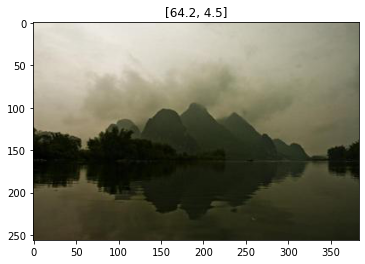

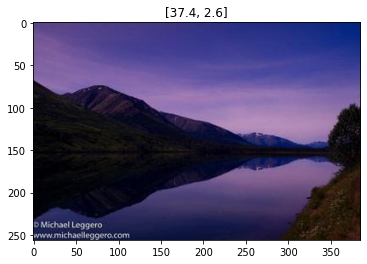

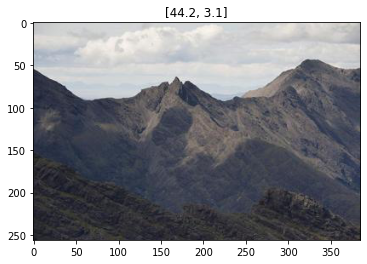

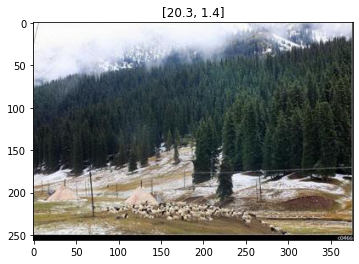

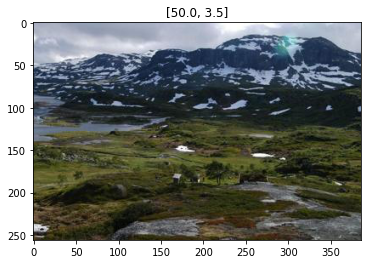

In [80]:
import matplotlib.pyplot as plt
score=[]
for i in range(5):
  dir=all_img_df['dir'][i]
  score.append([all_img_df['typicality_score'][i], all_img_df['7_score'][i]])
  img=Image.open(dir)
  plt.imshow(img)
  plt.title(score[i])
  plt.show()

In [82]:
all_img_df.groupby('type')['typicality_score', '7_score'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


typicality_score                        ... 7_score            
                      count       mean        std  ...     50%    75%  max
type                                               ...                    
Banana                 25.0  78.796000  29.298770  ...    6.60  7.000  7.0
Beach                  20.0  57.005000  18.502702  ...    4.30  4.775  5.7
Car                    16.0  42.656250  23.123090  ...    2.35  4.625  5.4
Church                 18.0  55.772222  18.756828  ...    3.45  4.900  6.2
Lighthouse             19.0  75.326316  25.595482  ...    5.90  6.500  6.9
Mountain               20.0  47.920000  20.500362  ...    3.50  4.525  6.0
Mug                    22.0  48.654545  17.945758  ...    3.40  4.075  6.1
Plane                  16.0  46.262500  22.409756  ...    2.65  4.350  6.5

[8 rows x 16 columns]